<a href="https://colab.research.google.com/github/im-hjk/dankook_dacon/blob/master/DACON_RFcv_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross val RF

## 라이브러리 import 및 설정

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import io
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [ ]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_dkdkdk')
data_dir = main_path / 'data/dacon-dku'
feature_dir = main_path / 'build/feature'
val_dir = main_path / 'build/val'
tst_dir = main_path / 'build/tst'
sub_dir = main_path / 'build/sub'

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [ ]:
algo_name = 'rfcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [ ]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 29)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nDetect,class,airmass,n_obMde,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,u/g,u/r,u/i,u/z,g/i,g/z,r/i,r/z,i/z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,0.0,1.1898,0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,1.1439,1.2238,1.3164,1.3733,1.1508,1.2005,1.0757,1.1222,1.0433,-2.6257,-3.3488,2.0462,0.7232
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1.0,1.2533,0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,1.0704,1.1189,1.1344,1.1430,1.0598,1.0678,1.0139,1.0215,1.0076,-0.7683,-0.8698,0.2767,0.1016
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,0.0,1.0225,0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,1.0607,1.0805,1.0905,1.0936,1.0281,1.0310,1.0093,1.0121,1.0028,-0.3649,-0.3905,0.1440,0.0257
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,3,0.0,1.2054,1,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,1.2111,1.2690,1.2898,1.3069,1.0650,1.0791,1.0164,1.0299,1.0133,-1.2000,-1.4395,0.5321,0.2395
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,12,0.0,1.1940,1,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,1.1814,1.2842,1.3345,1.3598,1.1296,1.1511,1.0392,1.0589,1.0190,-2.2436,-2.5579,0.9871,0.3144


In [ ]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 28) (80000, 28)


## Stratified K-Fold Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## Random Forest 모델 학습

In [ ]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 random_state=seed,
                                 n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.0344%


In [ ]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

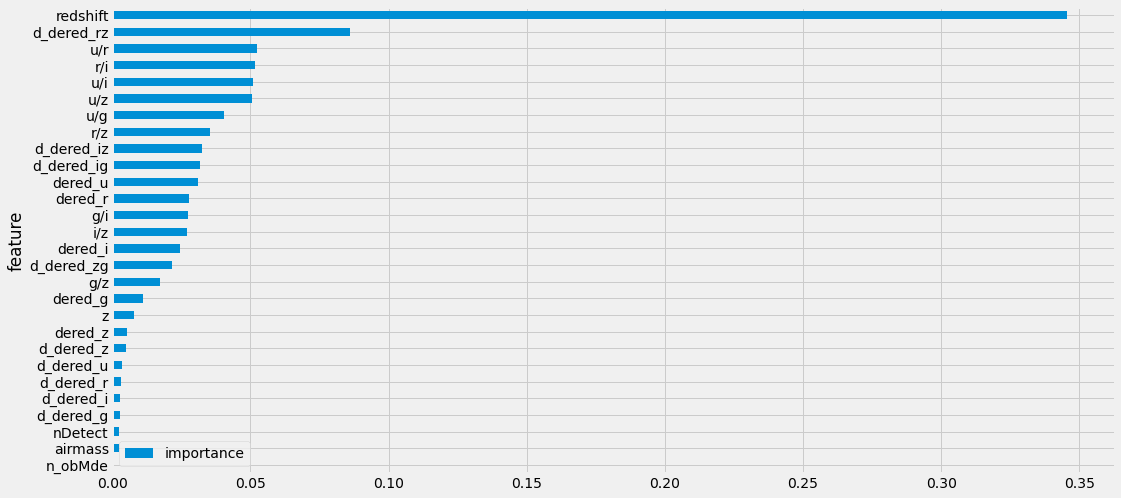

In [ ]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [ ]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [ ]:
sub[target_col].value_counts()

2    41396
0    29952
1     8652
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)